In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from pycocotools.coco import COCO
from torchvision import transforms
from pathlib import Path

from utils.data_loader import get_loader
from utils.model import EncoderCNN, DecoderRNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Step 1: Get Data Loader for Test Dataset

In [2]:
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.CenterCrop(224),                      # get 224x224 crop from center location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


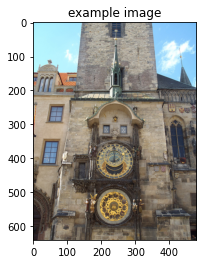

In [3]:
# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

## Step 2: Load Trained Models

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model_folder = Path("./models")

encoder_file = os.path.join(model_folder, "encoder-3.pkl")
decoder_file = os.path.join(model_folder, "decoder-3.pkl")

In [6]:
embed_size = 512
hidden_size = 512
num_layers = 3

vocab_size = len(data_loader.dataset.vocab)

In [7]:
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

encoder.eval()
decoder.eval()

encoder.load_state_dict(torch.load(encoder_file))
decoder.load_state_dict(torch.load(decoder_file))

encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embedding): Embedding(9955, 512)
  (lstm): LSTM(512, 512, num_layers=3, batch_first=True)
  (fc): Linear(in_features=512, out_features=9955, bias=True)
)

## Step 3: Finish the Sampler

In [8]:
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 372, 3574, 21, 3, 372, 39, 46, 18, 1, 18, 1, 1, 18, 1, 1, 18, 1, 1]


## Step 4: Clean up the Captions

In [9]:
def clean_sentence(output):
    
    words = []
    
    for entry in output:
        
        if entry == 0:
            continue
        
        if entry == 1:
            break
            
        words.append(data_loader.dataset.vocab.idx2word[entry])
        
    return ' '.join(words).capitalize()
        

In [10]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: A clock tower with a clock on it .


## Step 5: Generate Predictions

In [11]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

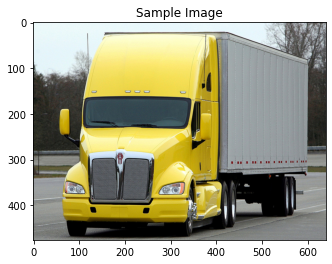

A truck is parked in a parking lot .


In [12]:
get_prediction()

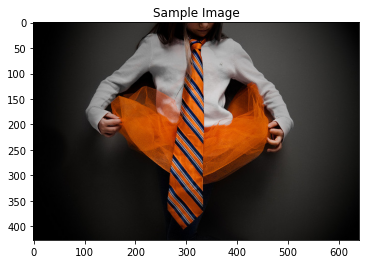

A man in a suit and tie is posing for a picture .


In [13]:
get_prediction()

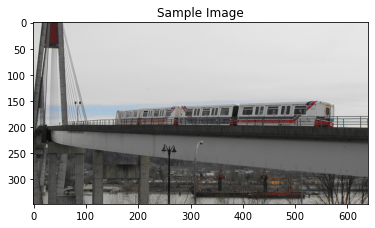

A train traveling down train tracks near a bridge .


In [14]:
get_prediction()

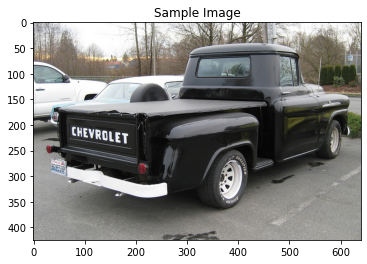

A truck is parked in a parking lot .


In [15]:
get_prediction()

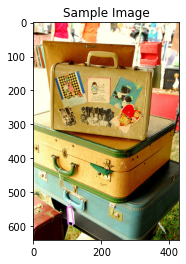

A kitchen with a stove , oven , and a stove top oven .


In [16]:
get_prediction()